Let's load our recordings and extract the spectrogram from a random recording:

In [1]:
from os import listdir
from random import choice
import pylab
import wave
#from scipy.io import wavfile

In [2]:
def wavInfo(rec_file):
    wav_file = wave.open(rec_file, 'r')
    frames = wav_file.readframes(-1)
    wave_info = pylab.fromstring(frames, 'Int16') #all .wavs in our dataset are 16bit
    framerate = wav_file.getframerate()
    wav_file.close()
    return wave_info, framerate

In [3]:
# show spectrogram 
def graphSpec(rec_file):
    wave_info, framerate = wavInfo(rec_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.xlabel("Time (s)")
    pylab.ylabel("Frequency (Hz)")
    pylab.subplot(111)
    pylab.title('Spectrogram of %s' % rec_file.split('/')[-1])
    spectrum, freqs, t, im = pylab.specgram(wave_info, NFFT=512, noverlap=256, window=pylab.window_hanning, Fs=framerate)
    pylab.show()
    #pylab.savefig("%s_spectrogram.png" % rec_file)

In [7]:
# get info. don't graph
def specInfo(rec_file):
    wave_info, framerate = wavInfo(rec_file)
    spectrum, freqs, t, _ = pylab.specgram(wave_info, NFFT=512, noverlap=256, window=pylab.window_hanning, Fs=framerate)
    del _
    return spectrum, freqs, t
    #pylab.savefig("%s_spectrogram.png" % rec_file)

Creating spectrogram of random recording from dataset


/home/asvnpr/.local/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


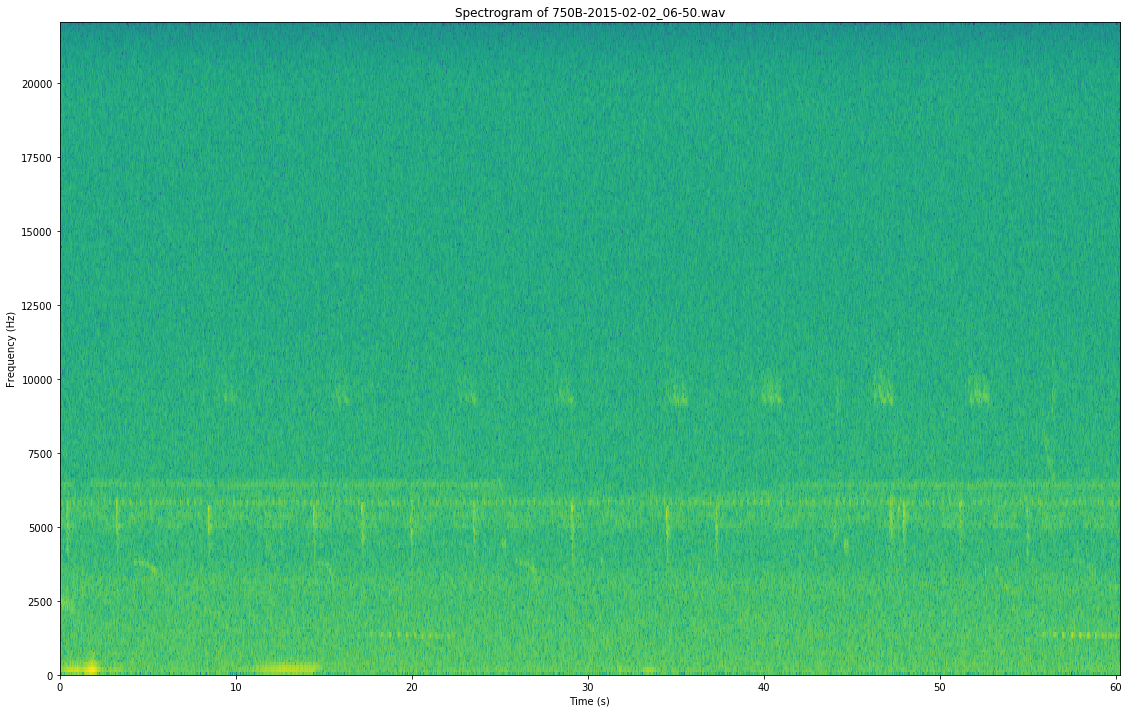

In [9]:
print("Creating spectrogram of random recording from dataset")
dataset_dir = '../dataset/recordings/'
recordings = listdir(dataset_dir) #put path to dataset in your machine. not uploading dataset to github
rec_file = dataset_dir + choice(recordings)
graphSpec(rec_file)
# periodograms, freqs, times, img = graphSpec(rec_file)
# print("image data: ", img)
# print("size of frequency data: ", len(freqs))
# print("frequency data: ", freqs)
# print("size of time data: ", len(times))
# print("time data: ", times)
# print("size of spectrum data", len(periodograms), " X ", len(periodograms[0]))
# print("spectrum data: ", periodograms)"""

pylab.specgram returns [4 things](http://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.specgram.html) :
* spectrum: a 2D array whose columns are the periodograms (see glossary) of successive segments
* freqs: a 1D array which contains the frequencies corresponding to the rows in spectrum 
* t: a 1D array which contains the times corresponding to the midpoint of segments (columns in spectrum)
* im: image of the spectrogram

In our case, freqs will be an array of size 257  
(44100 / 512 (number of points in our NFTT window) ~= 86.132 -> 22500 (Actual max freq) / 86.132 = 256 + 1 (for remaining frequency)  
Most of our recordings are ~1min and we end up with 6919 points in our time domain  
Each row in spectrum is a frequency value and each column in that row corresponds to the periodogram of a segment

We'll use the following functions to modify the results from our spectrogram and replot it with the data we need:  

In [10]:
# search for the index of the rightmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def leftmostBinSearch(A, lo, hi, target):
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 >= target):
        if (mid > 0 and A[mid - 1] > target):
            return leftmostBinSearch(A, lo, mid-1, target)
        else:
            return mid
    elif (A[mid] < target):
        return leftmostBinSearch(A, mid+1, hi, target)
    else:
        return leftmostBinSearch(A, lo, mid-1, target)

# search for the index of the leftmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def rightmostBinSearch(A, lo, hi, target): # something is wrong and it's giving me 1 to the right 
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 <= target):
        if (mid < (len(A) - 1) and A[mid + 1] <= target):
            return leftmostBinSearch(A, mid, hi, target)
        else:
            return mid
    elif (A[mid] < target):
        return leftmostBinSearch(A, mid+1, hi, target)
    else:
        return leftmostBinSearch(A, lo, mid-1, target)

In [11]:
# get modified spectrum of frequencies and times that matter to us
def specMod(spectrum, freqs, times, f1, f2, t1, t2):
    spectrumMod = [spectrum[f1][t1:t2]]
    for f in range(f1+1, f2): # check when fix right limit
            spectrumMod = spectrumMod+ [spectrum[f][t1:t2]]
    return spectrumMod

In [12]:
# based off: http://stackoverflow.com/questions/15961979/how-do-i-plot-a-spectrogram-the-same-way-that-pylabs-specgram-does
# plot the spectrogram of our region of interest
def plotModSpec(specMod, freqs, times, file):
    
    pylab.figure(num=None, figsize=(19, 12))
    pylab.xlabel("Time (s)")
    pylab.ylabel("Frequency (Hz)")
    pylab.title('Spectrogram of %s' % file.split('/')[-1])
    pylab.axis('tight')
    pylab.xlim(times[0],times[-1])
    pylab.pcolormesh(times, freqs, 10 * pylab.log10(specMod))
    pylab.axis('tight')
    pylab.ylim(freqs[0],freqs[-1])
    pylab.show()

/home/asvnpr/.local/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


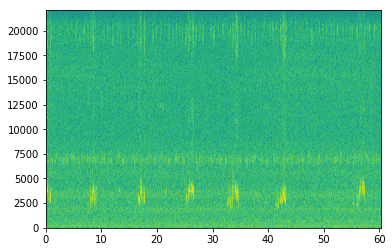

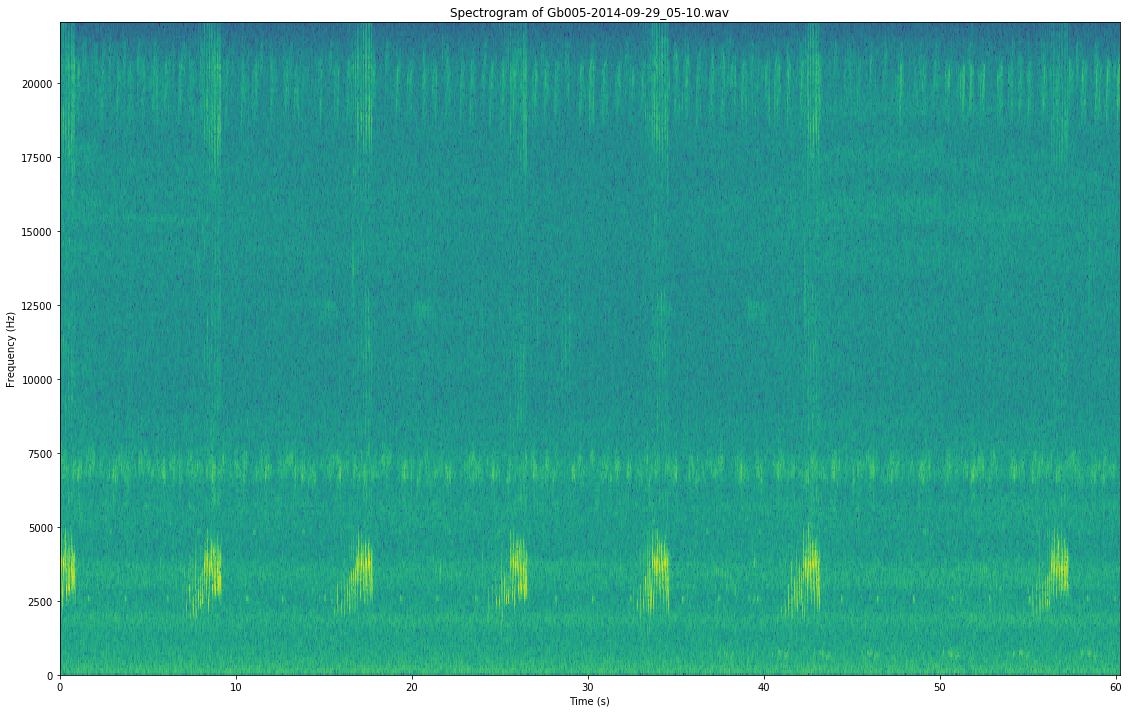

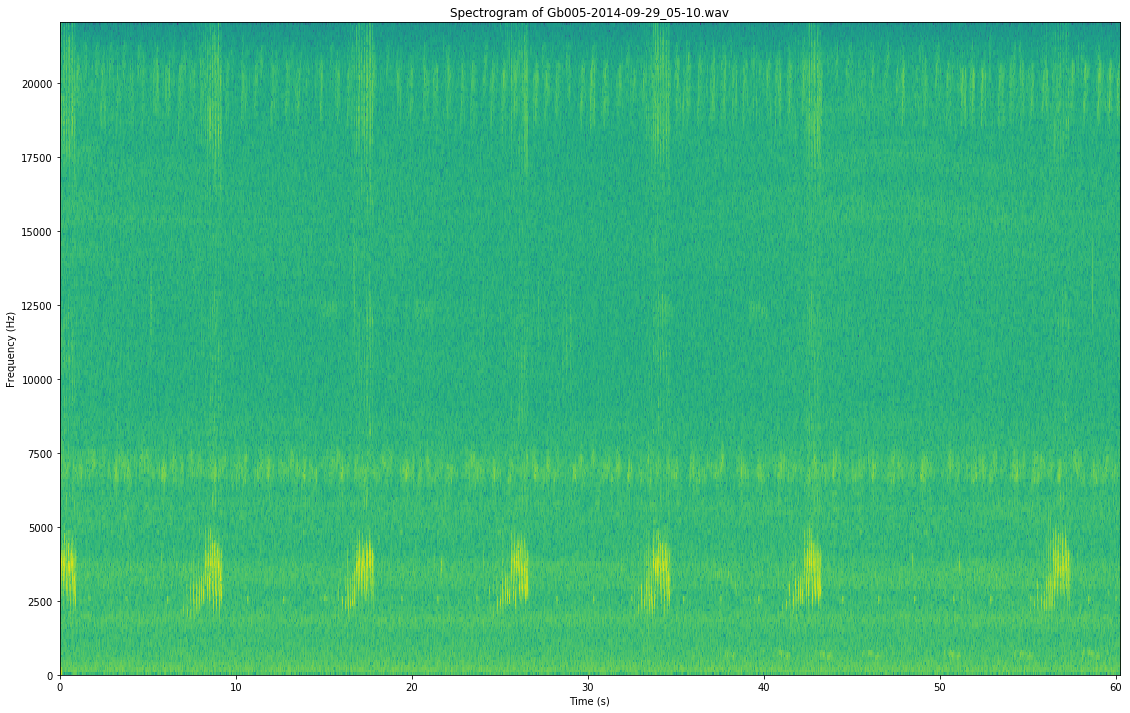

257  X  10378


In [13]:
test = '../dataset/recordings/Gb005-2014-09-29_05-10.wav'
spectrum, freqs, times = specInfo(test)
plotModSpec(spectrum, freqs, times, test)
graphSpec(test)
print(len(spectrum), " X ", len(spectrum[0]))

In [14]:
def getBounds(A, minVal, maxVal):
    left = leftmostBinSearch(A, 0, len(A)-1, minVal)
    right = rightmostBinSearch(A, 0, len(A)-1, maxVal)
    return left, right

times start at position:  7026  which is  40.7916553288
times end at position:  7429  which is  43.1310657596
freqs start at position:  21  which is  1808.7890625
freqs end at position:  63  which is  5426.3671875
dimmensions of specmod:  42  X  403


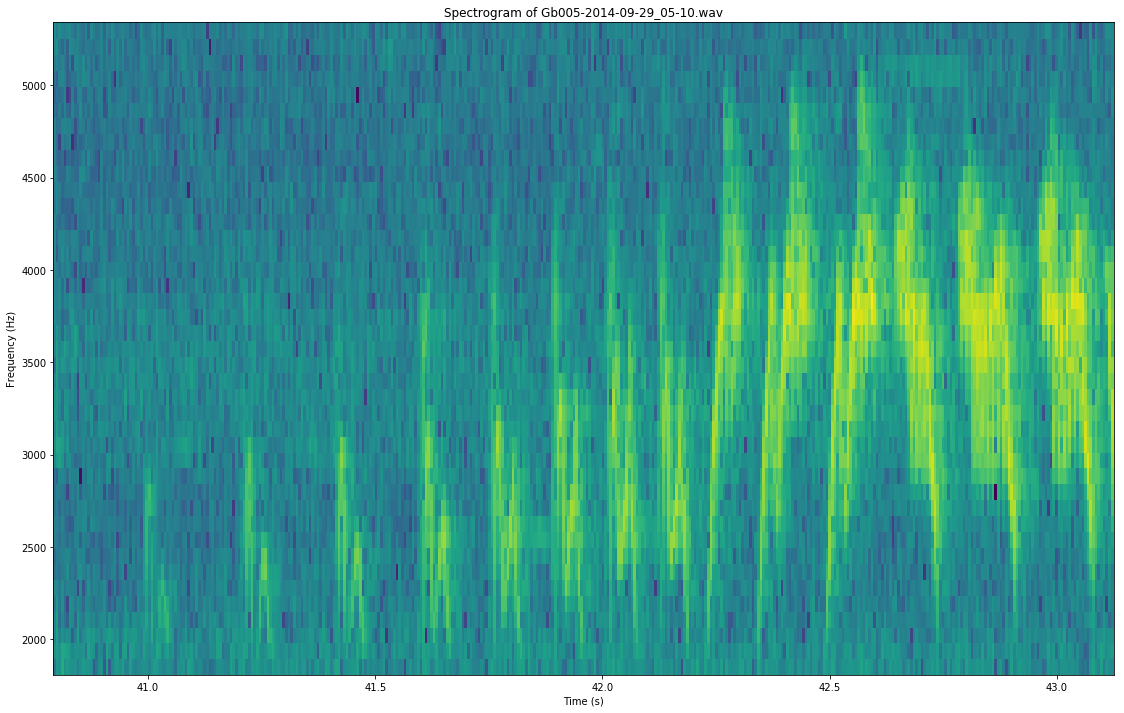

In [15]:
t_start, t_end = getBounds(times, 40.78952156, 43.1253411)
f_start, f_end = getBounds(freqs, 1805.818966, 5341.422414)

spectrumMod = specMod(spectrum, freqs, times, f_start, f_end, t_start, t_end)
print("times start at position: ", t_start, " which is ", times[t_start])
print("times end at position: ", t_end, " which is ", times[t_end])
print("freqs start at position: ", f_start, " which is ", freqs[f_start])
print("freqs end at position: ", f_end, " which is ", freqs[f_end])
print("dimmensions of specmod: ", len(spectrumMod), " X ", len(spectrumMod[0]))
freqMod = freqs[f_start:f_end]
timeMod = times[t_start:t_end]
plotModSpec(spectrumMod, freqMod, timeMod, test)

## References:
* [why pylab?](http://stackoverflow.com/questions/23451028/matplotlib-pyplot-vs-matplotlib-pylab)
* [.wav to spectrogram code](http://coreygoldberg.blogspot.com/2013/06/generating-audio-spectrograms-in-python.html)
* [general info about .wav files](https://web.archive.org/web/20140221054954/http://home.roadrunner.com/~jgglatt/tech/wave.htm)